#### Load `target placemnet positions`

In [ ]:
import numpy as np

# target_p = np.load('./data/ ...')

In [1]:
import roslib; roslib.load_manifest('ur_driver')
import rospy
import actionlib
import time
import copy
import math
import numpy as np
from control_msgs.msg import *
from trajectory_msgs.msg import *
from sensor_msgs.msg import JointState

""" FOR ONROBOT RG2 """
from pymodbus.client.sync import ModbusTcpClient  
""" FOR MODERN DRIVER """
import roslib; roslib.load_manifest('ur_driver')
import rospy
import sys
""" FOR UR5 """
import sys
sys.path.append('../../../')
from model.gripper import openGrasp, closeGrasp, resetTool
from model.RealRobot import RealRobot


ModuleNotFoundError: No module named 'roslib'

### Parsing Mujoco env

In [1]:
import copy
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../../")
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2quat
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


In [30]:
xml_path = '../../../asset/scene_realworld_wo_shelf.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([-0.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-0.05,0.80,0])

# Place objects
tray_pos = np.array([ 0.9, 0.0, 0.8])
bowl_red_pos = np.array([ 0.9, 0.3, 0.8])
bowl_blue_pos = np.array([ 0.9, -0.3, 0.8])
env.model.joint(env.model.body('tray_gray').jntadr[0]).qpos0[:3] = tray_pos
env.model.joint(env.model.body('kitchen-bowl-red').jntadr[0]).qpos0[:3] = bowl_red_pos
env.model.joint(env.model.body('kitchen-bowl-blue').jntadr[0]).qpos0[:3] = bowl_blue_pos

env.model.joint(env.model.body('ycb-apple-2').jntadr[0]).qpos0[:3] = bowl_red_pos + np.array([0.0,0.0,0.02])
env.model.joint(env.model.body('ycb-banana-2').jntadr[0]).qpos0[:3] = tray_pos + np.array([0.0,0.03,0.2])
env.model.joint(env.model.body('ycb-banana-2').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, 90])))
env.model.joint(env.model.body('ycb-lemon-2').jntadr[0]).qpos0[:3] = tray_pos + np.array([-0.03,-0.07,0.02])
env.model.joint(env.model.body('ycb-orange-2').jntadr[0]).qpos0[:3] = bowl_blue_pos + np.array([0.0,0.0,0.02])

# Target objects
env.model.joint(env.model.body('ycb-banana').jntadr[0]).qpos0[:3] = np.array([-5.0,-1.5,0.2])
env.model.joint(env.model.body('ycb-apple').jntadr[0]).qpos0[:3] = np.array([0.15, -0.8, 0.8])
env.model.joint(env.model.body('ycb-lemon').jntadr[0]).qpos0[:3] = np.array([0.075, -0.8, 0.8])
env.model.joint(env.model.body('ycb-orange').jntadr[0]).qpos0[:3] = np.array([0.0, -0.8, 0.8])

joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] in list1:
        idxs_step.append(list1.index(list2[i]))

window


In [31]:
# Origin
capture_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])

# Modified
# capture_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])

### Instantiate Real UR robot

In [ ]:
rospy.init_node('Pick_n_Place')
real_robot = RealRobot()

### Set to Initial Pose

In [3]:
capture_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
# capture_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])
q = copy.deepcopy(capture_q)
q_traj = JointTrajectory()

point = JointTrajectoryPoint()
point.positions = q
point.velocities = [0 for _ in range(6)]
point.time_from_start = rospy.Duration.from_sec(7.0)

q_traj.points.append(point)
real_robot.execute_arm_speed(q_traj, speed_limit=1.0)
real_robot.client.wait_for_result()

graspclient = ModbusTcpClient('192.168.0.22') 
resetTool(graspclient)
openGrasp(force=200, width=1000, graspclient=graspclient)
time.sleep(1)

NameError: name 'copy' is not defined

### `Perception`: table scene

In [32]:
def solve_ik(env:MuJoCoParserClass,body_name,p_trgt,R_trgt,IK_P,IK_R,q_init,idxs_forward, idxs_jacobian,
                RESET=False,DO_RENDER=False,render_every=1,th=1*np.pi/180.0,err_th=1e-6,w_weight=1.0, stepsize=1.0, eps=0.1,
                repulse = 30):
    """
        Solve IK
    """
    if RESET:
        env.reset()
    q_backup = env.get_q(joint_idxs=idxs_forward)
    q = q_init.copy()
    env.forward(q=q,joint_idxs=idxs_forward)
    tick = 0
    while True:
        tick = tick + 1
        J,err = env.get_ik_ingredients(
            body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=IK_P,IK_R=IK_R, w_weight=w_weight)
        dq = env.damped_ls(J,err,stepsize=stepsize,eps=eps,th=th)
        q = q + dq[idxs_jacobian]
        env.forward(q=q,joint_idxs=idxs_forward)

        p_contacts,f_contacts,geom1s,geom2s,body1s,body2s = env.get_contact_info(must_exclude_prefix='obj_')
        
        body1s_ = [obj_ for obj_ in body1s if obj_ not in ["rg2_gripper_finger1_finger_tip_link_collision","rg2_gripper_finger2_finger_tip_link_collision"]]
        body2s_ = [obj_ for obj_ in body2s if obj_ not in ["rg2_gripper_finger1_finger_tip_link_collision","rg2_gripper_finger2_finger_tip_link_collision"]]
        
        if len(body1s_) > 0:
            print(f"Collision with {body1s_[0]} and {body2s_[0]}")
            q = q - dq[idxs_jacobian] * repulse
        
        # Terminate condition
        err_norm = np.linalg.norm(err)
        if err_norm < err_th:
            break
        # Render
        if DO_RENDER:
            if ((tick-1)%render_every) == 0:
                p_tcp,R_tcp = env.get_pR_body(body_name=body_name)
                env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
                env.plot_T(p=p_trgt,R=R_trgt,PLOT_AXIS=True,axis_len=0.2,axis_width=0.005)
                env.render(render_every=render_every)
    # Back to back-uped position
    q_ik = env.get_q(joint_idxs=idxs_forward)
    env.forward(q=q_backup,joint_idxs=idxs_forward)
    
    return q_ik

In [33]:
env.forward(q=capture_q, joint_idxs=idxs_forward)
env.get_p_body('tcp_link')

array([0.14, 0.  , 1.14])

In [64]:
def solve_ik_for_target_name(env:MuJoCoParserClass, target_name, target_p, q_init, MODE='window'):
    env.init_viewer(viewer_title='UR5e with RG2 gripper and objects', viewer_width=1200, viewer_height=800,
                    MODE=MODE, viewer_hide_menus=True)
    env.update_viewer(azimuth=124.08, distance=4.00, elevation=-33, lookat=[0.1, 0.05, 0.86],
                    VIS_TRANSPARENT=False, VIS_CONTACTPOINT=True,
                    contactwidth=0.05, contactheight=0.05, contactrgba=np.array([1, 0, 0, 1]),
                    VIS_JOINT=False, jointlength=0.2, jointwidth=0.05, jointrgba=[0.2, 0.6, 0.8, 1.0])
    env.reset()  # reset
    env.forward(q=q_init, joint_idxs=env.idxs_forward)

    stepsize = 1.0
    render_every = 1
    th = 5*np.pi/180.0
    err_th = 1e-2
    repulse = 0
    eps = 0.5
    
    # Configuration
    DO_RENDER = True

    # 1. Turn UR Base
    body_name = 'tcp_link'
    p_base = env.get_p_body(body_name='base')
    p_trgt = env.get_p_body(target_name)
    p_trgt[1] = p_trgt[1] + 0.1
    p_trgt[2] = p_trgt[2] + 0.3
    R_trgt = rpy2r(np.radians([-180, 0, 0]))
    q_turn_base = solve_ik(env, eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_init, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 1. Solve IK for the pre-grasping position
    body_name = 'tcp_link'
    p_base = env.get_p_body(body_name='base')
    p_trgt = env.get_p_body(target_name)
    p_trgt[1] = p_trgt[1] + 0.1
    p_trgt[2] = p_base[2] + 0.05
    R_trgt = rpy2r(np.radians([-180, 0, 0]))
    q_pre_grasp = solve_ik(env, eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_turn_base, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    p_trgt = env.get_p_body(target_name)
    p_trgt[2] = p_base[2] + 0.05
    R_trgt = rpy2r(np.radians([-180, 0, 0]))
    q_grasp = solve_ik(env, eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_pre_grasp, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 2. Solve IK for the lift-up position
    p_trgt = env.get_p_body(target_name)
    p_trgt[2] = p_base[2] + 0.05 + 0.3
    R_trgt = rpy2r(np.radians([-180, 0, 0]))
    q_liftup = solve_ik(env, eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_grasp, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 3. Waypoint 1
    p_trgt = np.array([0.25, 0.  , 1.14])   # 0.14, 0, 1.14
    p_trgt[2] = p_base[2] + 0.05 + 0.3
    R_trgt = rpy2r(np.radians([-180, 0, 90]))
    q_waypoint1 = solve_ik(env, eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_liftup, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 4. Solve IK for the place position
    p_trgt = target_p.copy()
    # p_trgt[1] = p_base[0] + 0.7
    # p_trgt[2] = p_base[2] + 0.1 + 0.1
    R_trgt = rpy2r(np.radians([-180, 0, 90]))
    q_place = solve_ik(env, eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_waypoint1, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 5. Reset to init pose
    p_trgt = np.array([0.25, 0.  , 1.14])   # 0.14, 0, 1.14
    R_trgt = rpy2r(np.radians([-180, 0, 90]))
    q_reset = solve_ik(env, eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_place, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)


    # Close viewer
    env.close_viewer()
    print("IK done.")
    print("q_grasp:%s" % (np.degrees(q_grasp)))
    print("q_liftup:%s" % (np.degrees(q_liftup)))
    print("q_waypoint1:%s" % (np.degrees(q_waypoint1)))
    print("q_place:%s" % (np.degrees(q_place)))
    
    return [q_turn_base, q_pre_grasp, q_grasp, q_liftup, q_waypoint1, q_place, q_reset]

# Origin
capture_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
# Modified
# capture_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])

q_init = np.radians([0, -90, 0, 0, 0, 0])
q_init = q_init
q_list = []

p_target = np.array([0.6, 0.3, 0.85])
object_sequence = [0, 1, 2]
obj_names = ["ycb-apple", "ycb-lemon", "ycb-orange"]
obj_num = len(object_sequence)
for object_sequence_ in object_sequence:
    target_name = obj_names[object_sequence_]
    q_res = solve_ik_for_target_name(env, target_name, p_target, q_init)
    q_init = q_res[-1]
    q_list.append(q_res)

# target_name = obj_names[0]
# q_res = solve_ik_for_target_name(env, target_name, p_target, q_init)
# q_init = q_res[-1]
# q_list.append(q_res)


q_array = np.array(q_list)
print("planned joint trajectory:",q_array)

Collision with rg2_gripper_finger1_finger_tip_link and rg2_gripper_finger2_finger_tip_link
Collision with rg2_gripper_finger1_finger_tip_link and rg2_gripper_finger2_finger_tip_link
Collision with rg2_gripper_finger1_finger_tip_link and rg2_gripper_finger2_finger_tip_link
Collision with rg2_gripper_finger1_finger_tip_link and rg2_gripper_finger2_finger_tip_link
Collision with rg2_gripper_finger1_finger_tip_link and rg2_gripper_finger2_finger_tip_link
Collision with rg2_gripper_finger1_finger_tip_link and rg2_gripper_finger2_finger_tip_link
Collision with rg2_gripper_finger1_finger_tip_link and rg2_gripper_finger2_finger_tip_link
Collision with rg2_gripper_finger1_finger_tip_link and rg2_gripper_finger2_finger_tip_link
Collision with rg2_gripper_finger1_finger_tip_link and rg2_gripper_finger2_finger_tip_link
Collision with rg2_gripper_finger1_finger_tip_link and rg2_gripper_finger2_finger_tip_link
Collision with rg2_gripper_finger1_finger_tip_link and rg2_gripper_finger2_finger_tip_link

Joint trajectory ready. duration:[4.01]sec
Joint trajectory ready. duration:[1.07]sec
Joint trajectory ready. duration:[0.44]sec
Joint trajectory ready. duration:[1.13]sec
Joint trajectory ready. duration:[2.46]sec
Joint trajectory ready. duration:[2.99]sec
Joint trajectory ready. duration:[2.99]sec
Joint trajectory ready. duration:[2.17]sec
Joint trajectory ready. duration:[1.07]sec
Joint trajectory ready. duration:[0.47]sec
Joint trajectory ready. duration:[1.18]sec
Joint trajectory ready. duration:[2.29]sec
Joint trajectory ready. duration:[2.99]sec
Joint trajectory ready. duration:[2.99]sec
Joint trajectory ready. duration:[1.86]sec
Joint trajectory ready. duration:[1.15]sec
Joint trajectory ready. duration:[0.49]sec
Joint trajectory ready. duration:[1.23]sec
Joint trajectory ready. duration:[2.17]sec
Joint trajectory ready. duration:[2.99]sec
Joint trajectory ready. duration:[2.99]sec


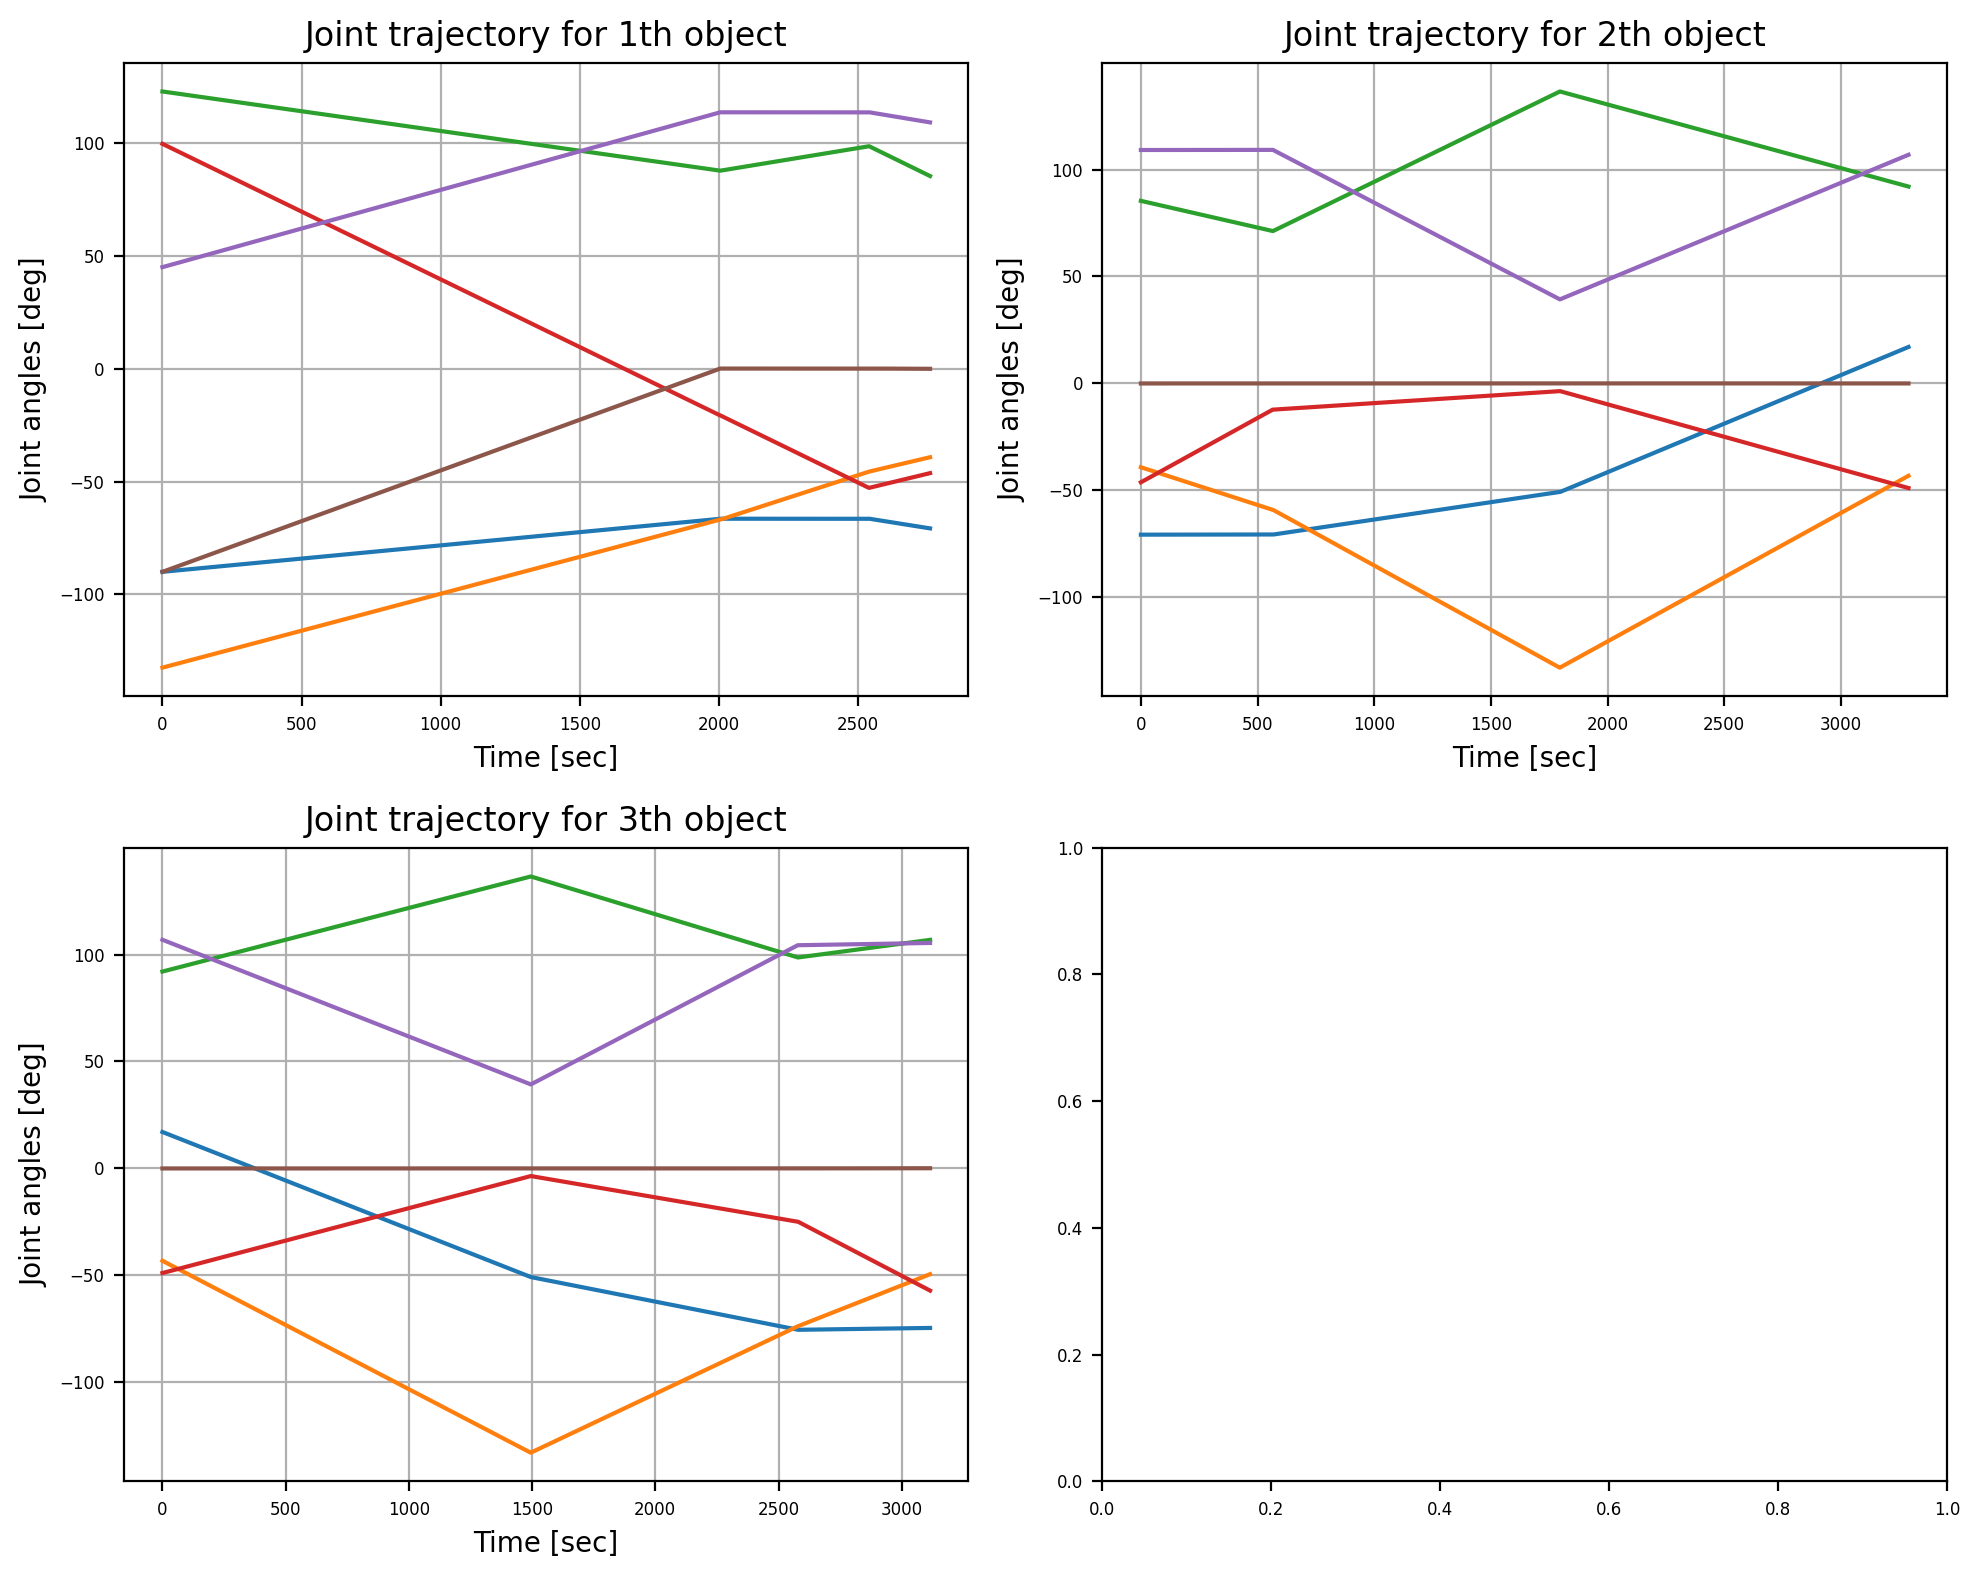

In [65]:
import matplotlib.pyplot as plt
from utils.util import get_interp_const_vel_traj

obj_num_sqrt = int(np.ceil(np.sqrt(obj_num)))
fig, axs = plt.subplots(obj_num_sqrt, obj_num_sqrt, figsize=(10, 8))

q_traj_list = []
times_list = []
q_array_flatten = np.concatenate([capture_q.reshape(1,6) ,q_array.reshape(-1,6)])
for q_before, q_after in zip(q_array_flatten[:-1], q_array_flatten[1:]):
    q_array_ = np.vstack([q_before, q_after])
    times, q_traj = get_interp_const_vel_traj(q_array_, vel=np.radians(30), HZ=env.HZ)
    print("Joint trajectory ready. duration:[%.2f]sec" % (times[-1]))
    
    q_traj_list.append(q_traj)
    times_list.append(times)

for i in range(obj_num):
    q_traj = np.concatenate(q_traj_list[obj_num*(i):obj_num*(i+1)])

    row = i // obj_num_sqrt
    col = i % obj_num_sqrt
    ax = axs[row, col]
    ax.plot(np.degrees(q_traj))
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Joint angles [deg]')
    ax.grid(True)
    title = "Joint trajectory for %dth object" % (i+1)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [66]:
# Gripper openning should be done by calling step()
env.init_viewer(viewer_title='UR5e with RG2 gripper and objects',viewer_width=1200,viewer_height=800,
                MODE='window', viewer_hide_menus=True)
env.update_viewer(azimuth=124.08,distance=4.00,elevation=-33,lookat=[0.1,0.05,0.86],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.2,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,1.0])

# Reset and initialize the joint position
env.reset() # reset

env.forward(q=capture_q,joint_idxs=env.idxs_forward)
env.update_viewer(azimuth=170,distance=2.5,lookat=env.get_p_body(body_name='tcp_link'))

        
# q_array_flatten = q_array.reshape(-1,6)

OPEN = True
CLOSE = False

grasp_list = [OPEN, OPEN, OPEN, CLOSE, CLOSE, CLOSE, OPEN]
grasp_len = len(grasp_list)

for i,q_traj_ in enumerate(q_traj_list):
    for q_ in q_traj_:
        start_time = env.get_sim_time()
        
        # while ((env.get_sim_time()-start_time) < time_margin[i%4]):
        
        env.step(ctrl=q_,ctrl_idxs=env.idxs_step)
        env.step(ctrl=float(grasp_list[i%grasp_len]),ctrl_idxs=6)

        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_base,R_base = env.get_pR_body(body_name='base')
        env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.005)
        env.render(render_every=10)

print ("Done.")

# Close viewer
env.close_viewer()

Done.


### Execute on Real-Robot UR5e

### Reset to Init capture pose

In [ ]:
# Reset to Init capture pose
q = copy.deepcopy(capture_q)
q_traj = JointTrajectory()

point = JointTrajectoryPoint()
point.positions = q
point.velocities = [0 for _ in range(6)]
point.time_from_start = rospy.Duration.from_sec(7.0)

q_traj.points.append(point)
real_robot.execute_arm_speed(q_traj, speed_limit=1.0)
real_robot.client.wait_for_result()


resetTool(graspclient)
openGrasp(force=200, width=1000, graspclient=graspclient)
time.sleep(1)

Waiting for server...
Connected to server
[array([-1.57, -2.31,  2.14,  1.74,  0.79, -1.57]), array([-1.57, -2.31,  2.14,  1.74,  0.79, -1.57])]
[-1.57 -2.31  2.14  1.74  0.79 -1.57] [-1.57 -2.31  2.14  1.74  0.79 -1.57]
diff_q:[-0.  0.  0. -0.  0.  0.]
diff_time:7.0
0.0001424479213495642
Finish plan
Tool reseting


In [ ]:
unit_time_base = 1.0
track_time = 0

q_curr = rospy.wait_for_message("joint_states", JointState).position
env.forward(q=q_curr,joint_idxs=idxs_forward)
x_before = env.get_p_body("tcp_link")
q_before = np.array(q_curr)

speed_limit = 0.3  # speed limit of EE velocity
q_speed_limit = 3.0 # speed limit of joint velocity
resetTool(graspclient)
openGrasp(force=200, width=1000, graspclient=graspclient)
time.sleep(1)

grasp_list = ['open', 'close', None,  'open']
q_array_flatten = q_array.reshape(-1,6)
for i, qs in enumerate(q_array_flatten):    
    q_traj = JointTrajectory()
    
    env.forward(q=qs,joint_idxs=idxs_forward)
    x_curr = env.get_p_body("tcp_link")
    delta_x = np.linalg.norm(x_curr - x_before)
    delta_q = np.linalg.norm(qs - q_before)
    
    unit_time = max(delta_q/q_speed_limit,max(delta_x/(speed_limit), unit_time_base))
    
    print(f"unit_time: {unit_time}")
    track_time = track_time + unit_time
    point = JointTrajectoryPoint()
    point.positions = qs
    point.velocities = [0 for _ in range(6)]
    point.time_from_start = rospy.Duration.from_sec(track_time + 2.0)
    q_traj.points.append(point)
    
    x_before = x_curr

    real_robot.execute_arm_speed(q_traj, speed_limit=1.6)
    real_robot.client.wait_for_result()
    time.sleep(0.5)

    if grasp_list[i%4] is None:
        continue
    elif grasp_list[i%4].lower() == 'open':
        openGrasp(force=200, width=1000, graspclient=graspclient)
    elif grasp_list[i%4].lower() == 'close':
        closeGrasp(force=200, width=100, graspclient=graspclient)
    else:
        raise ValueError('grasp_list must be None, open, or close')


Tool reseting
unit_time: 1.380397323988844
Waiting for server...
Connected to server
[array([-1.57, -2.31,  2.14,  1.74,  0.79, -1.57]), array([-0.91, -1.06,  2.38, -1.32,  0.66, -0.  ])]
[-0.91 -1.06  2.38 -1.32  0.66 -0.  ] [-1.57 -2.31  2.14  1.74  0.79 -1.57]
diff_q:[ 0.66  1.25  0.23 -3.06 -0.13  1.57]
diff_time:3.380397323
1.1019028530872375
Finish plan
unit_time: 1.2248238016952218
Waiting for server...
Connected to server
[array([-0.91, -1.06,  2.38, -1.32,  0.66, -0.  ]), array([-0.71, -0.95,  2.12, -1.17,  0.86,  0.  ])]
[-0.71 -0.95  2.12 -1.17  0.86  0.  ] [-0.91 -1.06  2.38 -1.32  0.66 -0.  ]
diff_q:[ 0.2   0.1  -0.26  0.15  0.2   0.  ]
diff_time:4.605221125
0.09234439846632927
Finish plan
unit_time: 1.0
Waiting for server...
Connected to server
[array([-0.71, -0.95,  2.12, -1.17,  0.86,  0.  ]), array([-0.71, -1.49,  1.85, -0.36,  0.86,  0.  ])]
[-0.71 -1.49  1.85 -0.36  0.86  0.  ] [-0.71 -0.95  2.12 -1.17  0.86  0.  ]
diff_q:[-0.   -0.54 -0.27  0.8  -0.    0.  ]
diff_ti